In [1]:
import geopandas
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline 

import seaborn as sns

from shapely.geometry import LineString
import contextily

import geoplot
import geoplot.crs as gcrs

## Introduction
Geospatial data is often available from specific GIS file formats or data stores, like ESRI shapefiles, GeoJSON files, geopackage files, PostGIS (PostgreSQL) database

For example, let's start by reading a shapefile with all the countries of the world (adapted from http://www.naturalearthdata.com/downloads/110m-cultural-vectors/110m-admin-0-countries/, zip file is available in the /data directory), and inspect the data:

And a dataset of rivers in the world (from http://www.naturalearthdata.com/downloads/50m-physical-vectors/50m-rivers-lake-centerlines/, zip file is available in the /data directory) where each river is a (multi-)line:

Shapely Library
the individual geometry objevts are provided by shapely library (see below)
1. geoseries

## Spatial relationships and operations

An important aspect of geospatial data is that we can look at spatial relationships: how two spatial objects relate to each other (whether they overlap, intersect, contain, .. one another).

The topological, set-theoretic relationships in GIS are typically based on the DE-9IM model. See https://en.wikipedia.org/wiki/Spatial_relation for more information.

1. Spatial join
2. Spatial overlay

In [152]:
countries = geopandas.read_file("zip://./data/ne_110m_admin_0_countries.zip")
rivers = geopandas.read_file("zip://./data/ne_50m_rivers_lake_centerlines.zip")
cities = geopandas.read_file("zip://./data/ne_110m_populated_places.zip")

# or if the archive is unpacked:
#countries = geopandas.read_file("/data/ne_110m_admin_0_countries/ne_110m_admin_0_countries.shp")


In [114]:
countries.head()


,iso_a3,name,continent,pop_est,gdp_md_est,geometry
0,AFG,Afghanistan,Asia,34124811.0,64080.0,"POLYGON ((61.21082 35.65007, 62.23065 35.27066..."
1,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -..."
2,ALB,Albania,Europe,3047987.0,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000..."
3,ARE,United Arab Emirates,Asia,6072475.0,667200.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407..."
4,ARG,Argentina,South America,44293293.0,879400.0,"MULTIPOLYGON (((-66.95992 -54.89681, -67.56244..."


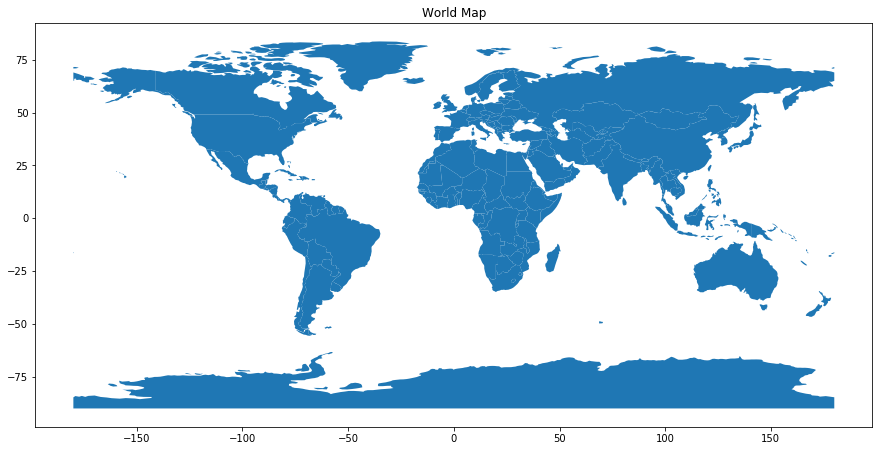

In [154]:
countries.plot(figsize=(15, 15))
plt.title('World Map')
plt.show()

In [116]:
type(countries)

geopandas.geodataframe.GeoDataFrame

In [117]:
countries.geometry

0      POLYGON ((61.21082 35.65007, 62.23065 35.27066...
1      MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...
2      POLYGON ((21.02004 40.84273, 20.99999 40.58000...
3      POLYGON ((51.57952 24.24550, 51.75744 24.29407...
4      MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...
                             ...                        
172    MULTIPOLYGON (((167.84488 -16.46633, 167.51518...
173    POLYGON ((52.00001 19.00000, 52.78218 17.34974...
174    POLYGON ((19.89577 -24.76779, 20.16573 -24.917...
175    POLYGON ((23.21505 -17.52312, 22.56248 -16.898...
176    POLYGON ((29.43219 -22.09131, 28.79466 -21.639...
Name: geometry, Length: 177, dtype: geometry

In [118]:
print(countries['pop_est'].mean())
print(countries['pop_est'].median())

41712369.84180791
9961396.0


In [119]:
africa = countries[countries['continent'] == 'Africa']

Text(0.5, 1, 'Africa')

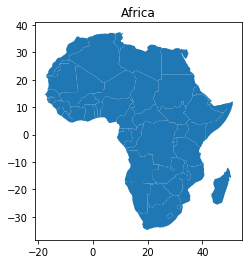

In [120]:
africa.plot()
plt.title('Africa')

## Shapely tutorial

In [121]:
from shapely.geometry import Point, Polygon, LineString


In [122]:
p = Point(1,1)
print(p)

POINT (1 1)


In [123]:
polygon = Polygon([(1,1) , (2,2) , (2,1)])

In [124]:
countries.crs


{'init': 'epsg:4326'}

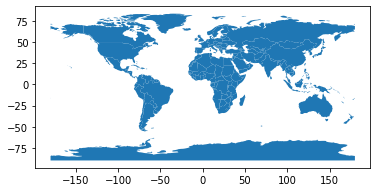

In [125]:
countries.plot()

In [126]:
print(cities.geometry[0])


POINT (12.45338654497177 41.90328217996012)


[(-40, 40), (-20, 60)]

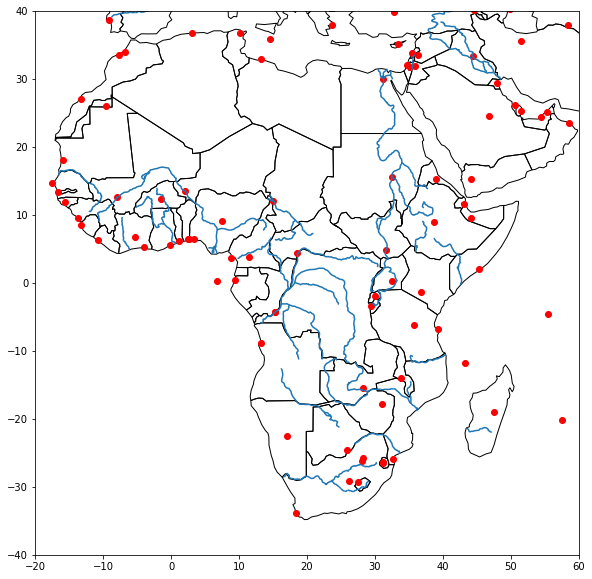

In [127]:
ax = countries.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
rivers.plot(ax=ax)
cities.plot(ax=ax, color='red')
ax.set(xlim=(-20, 60), ylim=(-40, 40))

## Spatial relationships and operations

### Relationship between individual objects

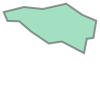

In [128]:
belgium = countries.loc[countries['name'] == 'Belgium', 'geometry'].squeeze()
belgium

In [129]:
africa = countries.loc[countries['name'] == 'Africa', 'geometry'].squeeze()


In [130]:
paris = cities.loc[cities['name'] == 'Paris', 'geometry'].squeeze()
brussels = cities.loc[cities['name'] == 'Brussels', 'geometry'].squeeze()

In [131]:
line = LineString([paris, brussels])

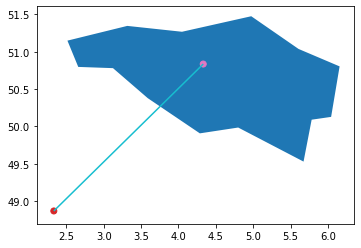

In [132]:
geopandas.GeoSeries([belgium, paris, brussels, line]).plot(cmap='tab10')

You can recognize the abstract shape of Belgium.

Brussels, the capital of Belgium, is thus located within Belgium. This is a spatial relationship, and we can test this using the individual shapely geometry objects as follow

In [133]:
brussels.within(belgium)

True

In [134]:
belgium.contains(brussels)


True

### Spatial relationships with GeoDataFrames
The same methods that are available on individual shapely geometries as we have seen above, are also available as methods on GeoSeries / GeoDataFrame objects.

For example, if we call the contains method on the world dataset with the paris point, it will do this spatial check for each country in the world dataframe:

In [135]:
countries.contains(paris)


0      False
1      False
2      False
3      False
4      False
       ...  
172    False
173    False
174    False
175    False
176    False
Length: 177, dtype: bool

In [136]:
countries[countries.contains(paris)]

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
55,FRA,France,Europe,67106161.0,2699000.0,"MULTIPOLYGON (((2.51357 51.14851, 2.65842 50.7..."


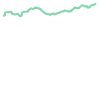

In [137]:
amazon = rivers[rivers['name'] == 'Amazonas'].geometry.squeeze()
amazon

In [138]:
countries[countries.crosses(amazon)]

,iso_a3,name,continent,pop_est,gdp_md_est,geometry
22,BRA,Brazil,South America,207353391.0,3081000.0,"POLYGON ((-57.62513 -30.21629, -56.29090 -28.8..."
35,COL,Colombia,South America,47698524.0,688000.0,"POLYGON ((-66.87633 1.25336, -67.06505 1.13011..."
124,PER,Peru,South America,31036656.0,410400.0,"POLYGON ((-69.52968 -10.95173, -68.66508 -12.5..."


In [139]:
brazil = countries.loc[countries['name'] == 'Brazil', 'geometry'].squeeze()
Columbia = countries.loc[countries['name'] == 'Columbia', 'geometry'].squeeze()
peru = countries.loc[countries['name'] == 'Peru', 'geometry'].squeeze()

geopandas.GeoSeries([brazil,amazon,Columbia,peru]).plot(alpha=0.5, cmap='tab10')


IndexError: too many indices for array

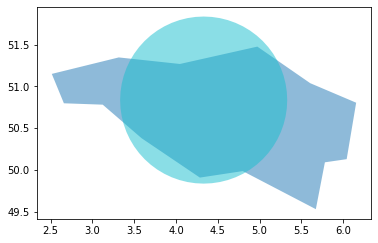

In [140]:
geopandas.GeoSeries([belgium, brussels.buffer(1) ]).plot(alpha=0.5, cmap='tab10')


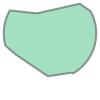

In [141]:
brussels.buffer(1).intersection(belgium)


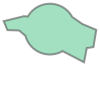

In [142]:
brussels.buffer(1).union(belgium)


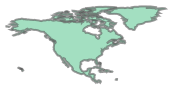

In [168]:
africa_countries = countries[countries['continent'] == 'North America']
africa = africa_countries.unary_union
africa

In [144]:
print(str(africa)[:1000])


MULTIPOLYGON (((49.54351891459575 -12.46983285894055, 49.80898074727909 -12.89528492599955, 50.05651085795716 -13.55576140712198, 50.21743126811407 -14.7587887508768, 50.47653689962553 -15.22651213955054, 50.37711144389596 -15.70606943121913, 50.20027469259318 -16.00026336025677, 49.86060550313868 -15.41425261806692, 49.67260664246086 -15.71020354580248, 49.86334435405016 -16.45103687913878, 49.77456424337271 -16.8750420060936, 49.49861209493412 -17.10603565843827, 49.43561852397031 -17.95306406013437, 49.04179243347394 -19.11878101977445, 48.54854088724801 -20.49688811613413, 47.93074913919867 -22.39150115325108, 47.54772342305131 -23.78195891692852, 47.0957613462266 -24.94162973399045, 46.28247765481709 -25.17846282318411, 45.40950768411045 -25.60143442149309, 44.83357384621755 -25.34610116953894, 44.03972049334976 -24.98834522878231, 43.76376834491117 -24.46067717864999, 43.69777754087445 -23.5741163062506, 43.34565433123763 -22.77690398528387, 43.254187046081 -22.05741301848412, 43

In [145]:
cities2 = cities[cities['name'].isin(['Bern', 'Brussels', 'London', 'Paris'])].copy()
cities2['iso_a3'] = ['CHE', 'BEL', 'GBR', 'FRA']
countries2 = countries[['iso_a3', 'name', 'continent']]
cities2

,name,geometry,iso_a3
26,Bern,POINT (7.46698 46.91668),CHE
170,Brussels,POINT (4.33137 50.83526),BEL
219,London,POINT (-0.11867 51.50194),GBR
235,Paris,POINT (2.33139 48.86864),FRA


In [146]:
france = countries.loc[countries['name'] == 'France', 'geometry'].squeeze()
cities.within(france)
cities3 = cities[cities.within(france)]
cities3

,name,geometry
10,Monaco,POINT (7.40691 43.73965)
13,Andorra,POINT (1.51649 42.50000)
186,Geneva,POINT (6.14003 46.21001)
235,Paris,POINT (2.33139 48.86864)


In [147]:
#spatialjoin operation
joined = geopandas.sjoin(cities, countries, op='within', how='left')
joined.head(5)

,name_left,geometry,index_right,iso_a3,name_right,continent,pop_est,gdp_md_est
0,Vatican City,POINT (12.45339 41.90328),79.0,ITA,Italy,Europe,62137802.0,2221000.0
1,San Marino,POINT (12.44177 43.93610),79.0,ITA,Italy,Europe,62137802.0,2221000.0
2,Vaduz,POINT (9.51667 47.13372),9.0,AUT,Austria,Europe,8754413.0,416600.0
3,Lobamba,POINT (31.20000 -26.46667),152.0,SWZ,Swaziland,Africa,1467152.0,11060.0
4,Luxembourg,POINT (6.13000 49.61166),97.0,LUX,Luxembourg,Europe,594130.0,58740.0


In [148]:
joined['continent'].value_counts()

Asia             59
Africa           57
Europe           46
North America    26
South America    14
Oceania           8
Name: continent, dtype: int64

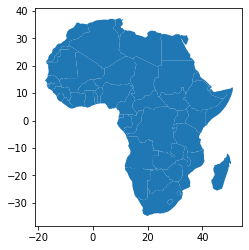

In [149]:
africa = countries[countries['continent'] == 'Africa']
africa.plot()

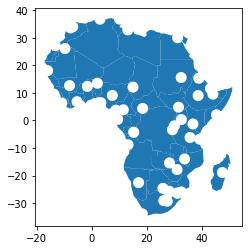

In [150]:
cities['geometry'] = cities.buffer(2)
geopandas.overlay(africa, cities, how='difference').plot()

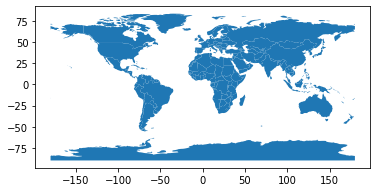

In [157]:
countries = countries[(countries['pop_est'] >0 ) & (countries['name'] != "Antarctica")]
countries['gdp_per_cap'] = countries['gdp_md_est'] / countries['pop_est'] * 100

countries.head(5)

,iso_a3,name,continent,pop_est,gdp_md_est,geometry,gdp_per_cap
0,AFG,Afghanistan,Asia,34124811.0,64080.0,"POLYGON ((61.21082 35.65007, 62.23065 35.27066...",0.187781
1,AGO,Angola,Africa,29310273.0,189000.0,"MULTIPOLYGON (((23.90415 -11.72228, 24.07991 -...",0.644825
2,ALB,Albania,Europe,3047987.0,33900.0,"POLYGON ((21.02004 40.84273, 20.99999 40.58000...",1.112209
3,ARE,United Arab Emirates,Asia,6072475.0,667200.0,"POLYGON ((51.57952 24.24550, 51.75744 24.29407...",10.987283
4,ARG,Argentina,South America,44293293.0,879400.0,"MULTIPOLYGON (((-66.95992 -54.89681, -67.56244...",1.985402


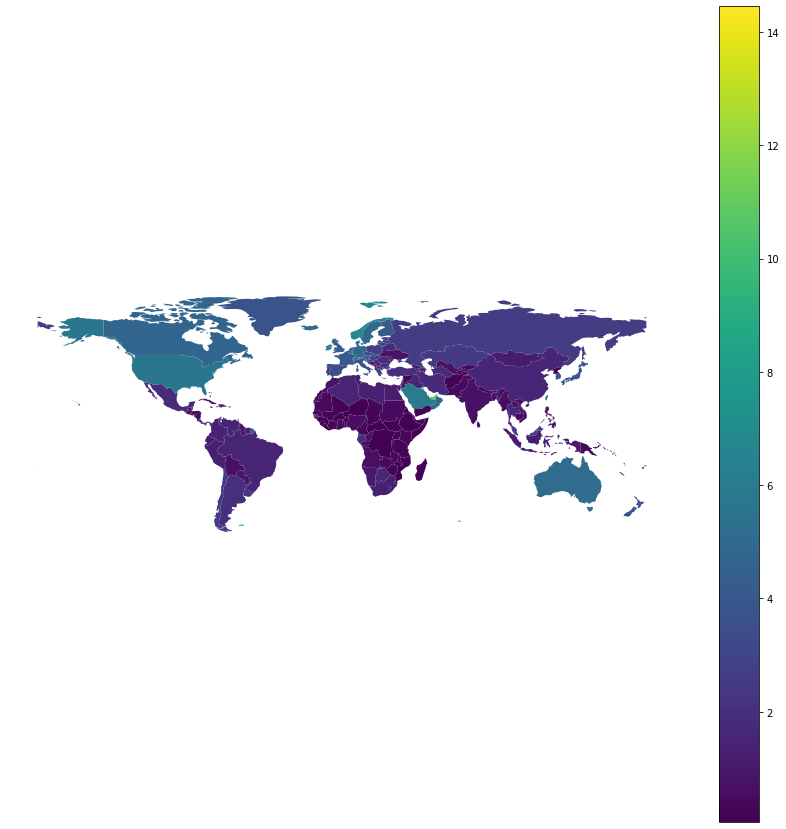

In [160]:
ax = countries.plot(figsize=(15, 15), column='gdp_per_cap', legend=True)
ax.set_axis_off()

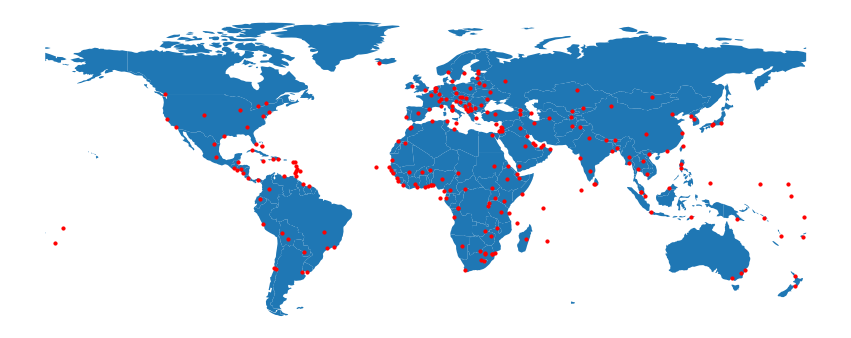

In [161]:
ax = countries.plot(figsize=(15, 15))
cities.plot(ax=ax, color='red', markersize=10)
ax.set_axis_off()

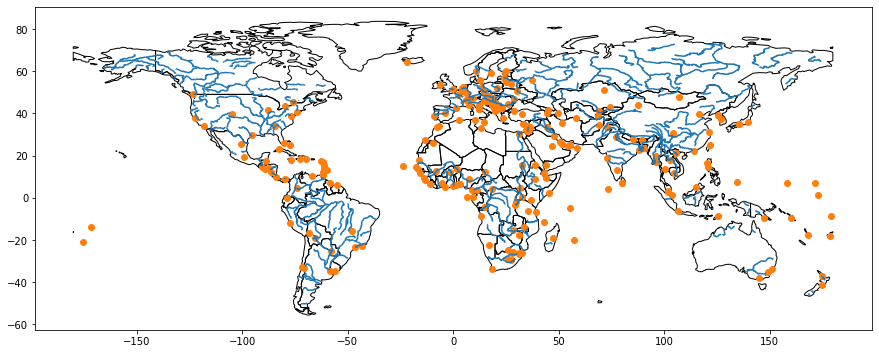

In [163]:
ax = countries.plot(edgecolor='k', facecolor='none', figsize=(15, 10))
rivers.plot(ax=ax)
cities.plot(ax=ax, color='C1')
#ax.set(xlim=(-20, 60), ylim=(-40, 40))


In [ ]:
# selecting these cities in Europe
cities_europe = cities[cities.within(countries[countries['continent'] == 'Europe'].unary_union)]

